# Musical Bootstrap

**Fitting procedure**: To fit each distribution, we follow the method outlined in Clauset et al. 2009. We use maximum likelihood estimation to estimate the parameters of each distribution, and we select the lower bound $x_{min}$ by minimizing the KS distance between the cdf of the hypothesized model and the emprical cdf. We also test goodness-of-fit without setting a lower bound $x_{min}$.

**Bootstraping procedure**: We also follow Clauset et al.'s method to bootstrap. We use their semi-parametric approach when building synthetic data sets. With probability $ p = {n_{tail}}/{n}$, we sample from the hypothesized model and with probability $1 - p$, we sample from the empirical distribution below $x_{min}$. Our $p$-values are calculated as the proportion of synthetic statistics that are greater than the fit statistic.

The bootstrap code can be found in `bootstrap.py` and the distribution fitting code, which is called by `bootstrap.py`, can be found in `distributions.py`.

---

## Summary

The following $p$-values are calculated as the proportion of synthetic $D$ statistics that are greater than the empirical $D$, where $D$ is the KS distance between the hypothesized model and the empirical distribution.

### Melodic bigrams

#### No $x_{min}$

| Distribution |$p_D$ |
| :-  | :-:|
| power-law | 0.000 |
| lognormal   | 0.000 |
|positive lognormal | 0.000 |
| stretched exponential  | 0.000 |
| exponential   | 0.000 ||
| power-law with cutoff  | 0.000|

#### Estimating $x_{min}$ by minimizing KS 

| Distribution | $x_{min}$ | % of data above $x_{min}$ |$p_D$ |
| :- | :-: | :-: | :-:|
| power-law | 15.0 | 5.77 | 0.000 |
| lognormal | 19 | 1.74 | 0.009 |
| positive lognormal | 19 | 1.74 | 0.008 |
| stretched exponential | 5 | 29.63 | 0.000 |
| exponential | 20 | 1.03 | 0.000 |
| power-law with cutoff | 2 | 57.85 | 0.000* |

*100 iterations completed at time of writing


-----

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('dark')

In [4]:
pitch = pd.read_csv('../data/pitch_ranks.csv')['ranks']

In [5]:
def plot_ecdf(fit, pdf_base_function):
    fig, ax = plt.subplots(figsize=(10, 6))
    n, bins, patches = ax.hist(fit.data, len(np.unique(fit.data)), density=True, histtype='step',
                               cumulative=True, label='Empirical', color='k')
    y = pdf_base_function(bins)
    y = y.cumsum()
    y /= y[-1]

    ax.plot(bins, y, 'r--', linewidth=1.5, label='Theoretical \n D = %.3f' % dist.D)

    # tidy up the figure
    ax.grid(True)
    ax.legend(loc='right')
    ax.set_title('Theoretical and empircal CDF')
    ax.set_xlabel('relative bigram rank')
    ax.set_ylabel('P(X <= x)')

    plt.show()

In [6]:
def print_params(dist):
    print('Fit parameters:')
    print('\t xmin =', dist.xmin)
    for param, param_name in zip(dist.get_parameters(), dist.get_parameter_names()):
        print('\t %s =' % param_name, param)
    print('\t D =', dist.D)

In [7]:
def get_p_values(dist, bootstrap):
    print('p-values:')
    p = len(list(filter(lambda x: x > dist.D, bootstrap['D'])))/len(bootstrap)
    print('\t p_D = %.4f' % p)
    p = len(list(filter(lambda x: x > dist.xmin, bootstrap['xmin'])))/len(bootstrap)
    print('\t p_xmin =', p)
    for param, param_name in zip(dist.get_parameters(), dist.get_parameter_names()):
        p = len(list(filter(lambda x: x > param, bootstrap[param_name])))/len(bootstrap)
        print('\t p_%s =' % param_name, p)

In [182]:
def plot_bootstrap(dist, boot, bin_norm=30):
    fig, axs = plt.subplots(2, 2, figsize=(9, 11))
    N, bins, patches = axs[0, 0].hist(boot.xmin, 
                                      bins=20 if len(np.unique(boot.xmin)) == 1 else len(np.unique(boot.xmin)), 
                                     label='mean = %.3f\nstd = %.3f' % (np.mean(boot.xmin), np.std(boot.xmin)))
    axs[0,0].set(ylabel='frequency')
    axs[0,0].grid(True)
    axs[0, 0].set_title('x_min')
    axs[0, 0].legend()
    N, bins, patches = axs[0,1].hist(boot.D, bins=int(len(np.unique(boot.D))/bin_norm), 
                                     label='mean = %.3f\nstd = %.3f' % (np.mean(boot.D), np.std(boot.D)))
    axs[0, 1].set_title('D')
    axs[0,1].grid(True)
    axs[0,1].legend()
    params = dist.get_parameters()
    names = dist.get_parameter_names()
    i = 0 
    for n,p in zip(names, params):
        N, bins, patches = axs[1, i].hist(boot[n], bins=int(len(np.unique(boot[n]))/bin_norm),
                                         label='mean = %.3f\nstd = %.3f' % (np.mean(boot[n]), np.std(boot[n])))
        axs[1, i].set_title(n)
        axs[1,i].grid(True)
        axs[1,i].legend()
        if i == 1:
            axs[1,i].set(xlabel='estimate')
        else:
            axs[1,i].set(xlabel='estimate', ylabel='frequency')
        i+=1
    if i == 1: 
        axs[0, 1].set(xlabel='estimate')
        fig.delaxes(axs[1,1])
    st = fig.suptitle('Bootstrap parameter estimate histograms')
    #fig.tight_layout()
    st.set_y(0.90)
    fig.subplots_adjust(top=0.85)

In [9]:
def get_local_minima(dist):    
    Ds = dist.Ds
    Ds.sort(key=lambda l: l[1])
    Ds = [d[-1] for d in Ds]
    return [i+1 for i in range(1,len(Ds)-1) if Ds[i-1] > Ds[i] and Ds[i+1] > Ds[i]]

In [10]:
from distributions import Exponential, Lognormal, Stretched_exponential, Powerlaw_with_cutoff, Powerlaw, Positive_lognormal

---

Text(0.5, 1.0, 'Histrogram of pitch bigram ranks')

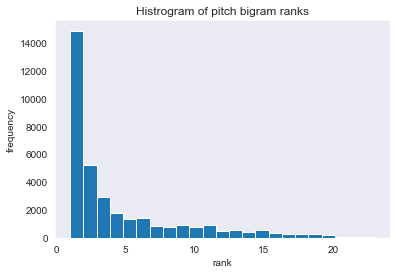

In [11]:
n = plt.hist(pitch, bins=len(np.unique(pitch)))
plt.xlabel('rank')
plt.ylabel('frequency')
plt.title('Histrogram of pitch bigram ranks')

----
## Exponential

In [176]:
pitch_exp_noxmin = pd.read_csv('bootstrap_data/pitch_exp_bootstrap_1e3_xmin1.csv')

In [177]:
dist = Exponential(pitch, xmin=1) # "no xmin"

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [178]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 lambda = 0.2709148583931702
	 D = 0.1842110619286569


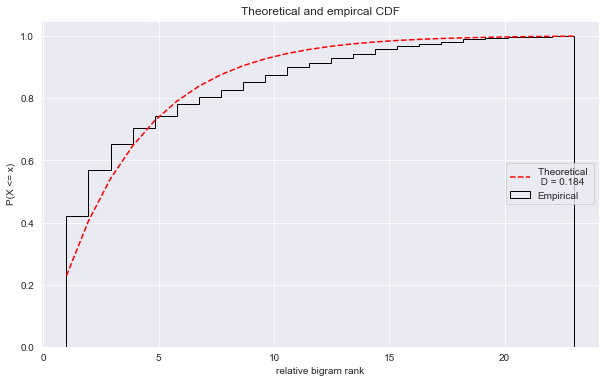

In [179]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [180]:
get_p_values(dist,pitch_exp_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_lambda = 0.491


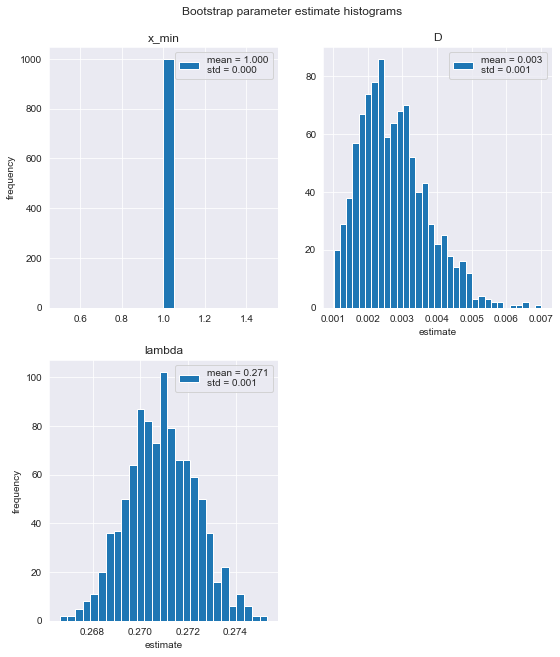

In [183]:
plot_bootstrap(dist, pitch_exp_noxmin)

In [184]:
exp_xmin = pd.read_csv('bootstrap_data/pitch_exp_bootstrap_1e3.csv')

In [185]:
# using min KS value as estimate for xmin
dist = Exponential(pitch)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [186]:
print_params(dist)

Fit parameters:
	 xmin = 20.0
	 lambda = 0.726211847356715
	 D = 0.045449605050046804


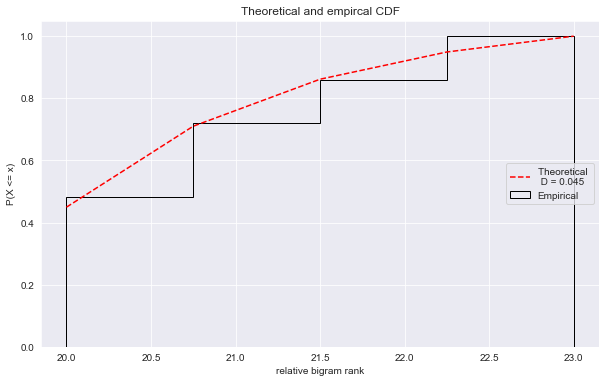

In [187]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [188]:
get_p_values(dist, exp_xmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.303
	 p_lambda = 0.546


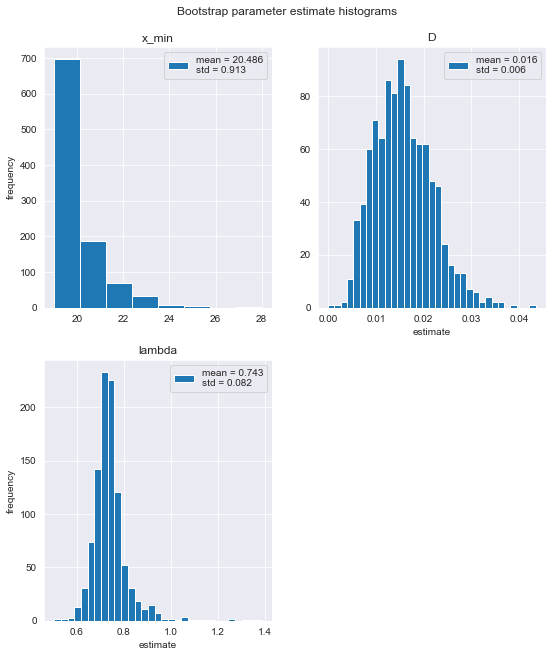

In [189]:
plot_bootstrap(dist, exp_xmin)

---
## Lognormal

In [190]:
lognormal_boot_noxmin = pd.read_csv('bootstrap_data/pitch_ln_bootstrap_1e3_xmin1.csv')

In [191]:
# fit data to lognormal
dist = Lognormal(pitch, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


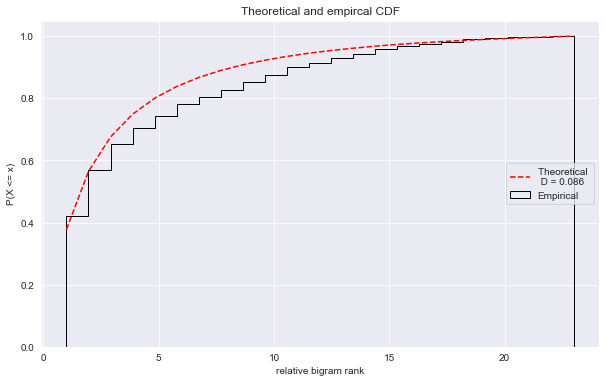

In [192]:
plot_ecdf(dist, dist.fit.lognormal._pdf_base_function)

In [193]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 mu = 0.23091265462201804
	 sigma = 1.4443751358886332
	 D = 0.08607187713728676


In [194]:
get_p_values(dist, lognormal_boot_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_mu = 1.0
	 p_sigma = 0.0


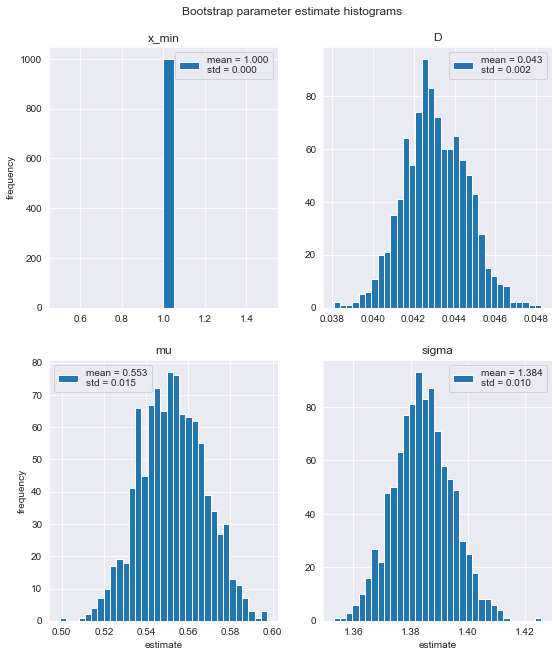

In [195]:
plot_bootstrap(dist, lognormal_boot_noxmin)

In [249]:
lognormal_boot = pd.read_csv('bootstrap_data/pitch_ln_bootstrap_1e3.csv')

In [250]:
dist = Lognormal(pitch)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [251]:
print_params(dist)

Fit parameters:
	 xmin = 19.0
	 mu = 2.9145764980969777
	 sigma = 0.10394131858896394
	 D = 0.0504010146320546


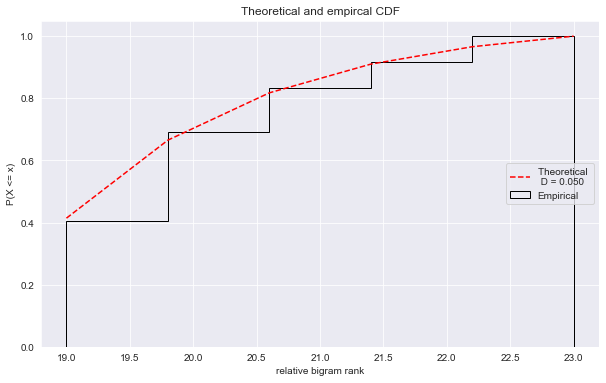

In [252]:
plot_ecdf(dist, dist.fit.exponential._pdf_base_function)

In [253]:
get_p_values(dist, lognormal_boot)

p-values:
	 p_D = 0.0090
	 p_xmin = 0.934
	 p_mu = 0.146
	 p_sigma = 0.77


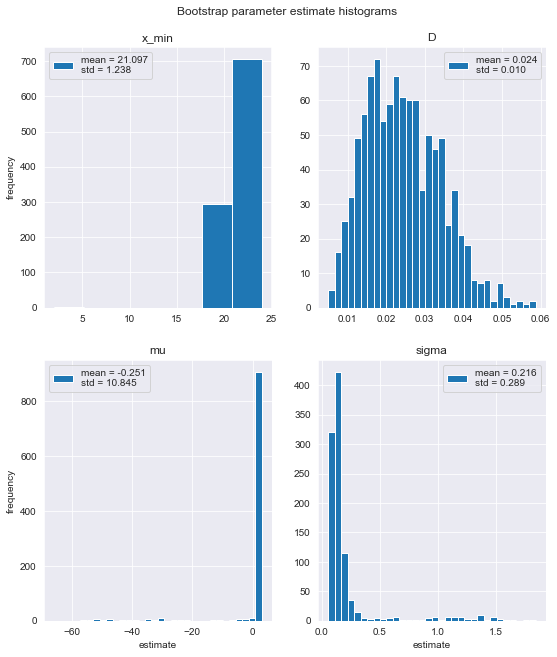

In [254]:
plot_bootstrap(dist, lognormal_boot)

## Positive lognormal

In [202]:
pos_ln_noxmin = pd.read_csv('bootstrap_data/pitch_pos_ln_bootstrap_1e3_xmin.csv')

In [203]:
dist = Positive_lognormal(pitch, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [204]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 mu = 0.2309106739461412
	 sigma = 1.444366131261042
	 D = 0.08606978681392707


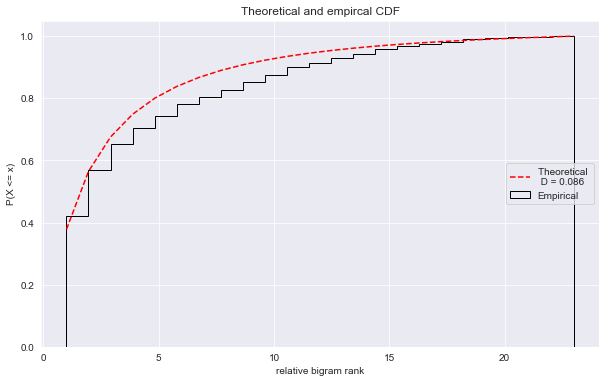

In [205]:
plot_ecdf(dist, dist.fit.lognormal_positive._pdf_base_function)

In [206]:
get_p_values(dist, pos_ln_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_mu = 1.0
	 p_sigma = 0.0


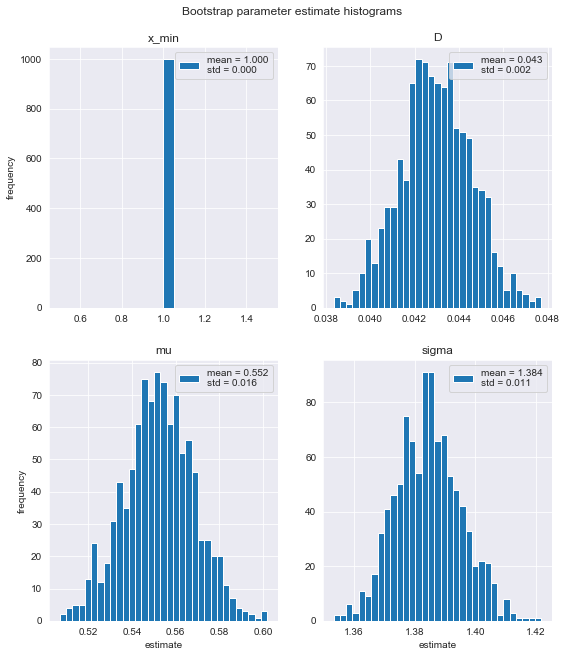

In [207]:
plot_bootstrap(dist, pos_ln_noxmin)

In [208]:
pos_ln = pd.read_csv('bootstrap_data/pitch_pos_ln_bootstrap_1e3.csv')

In [209]:
dist = Positive_lognormal(pitch)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [210]:
print_params(dist)

Fit parameters:
	 xmin = 19.0
	 mu = 2.9145764980969777
	 sigma = 0.10394131858896394
	 D = 0.0504010146320546


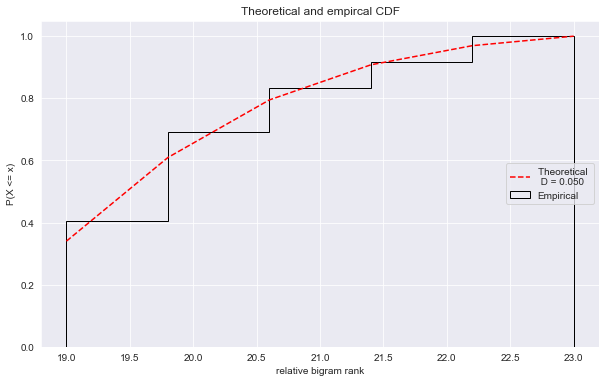

In [211]:
plot_ecdf(dist, dist.fit.lognormal_positive._pdf_base_function)

In [212]:
get_p_values(dist, pos_ln)

p-values:
	 p_D = 0.0080
	 p_xmin = 0.924
	 p_mu = 0.144
	 p_sigma = 0.769


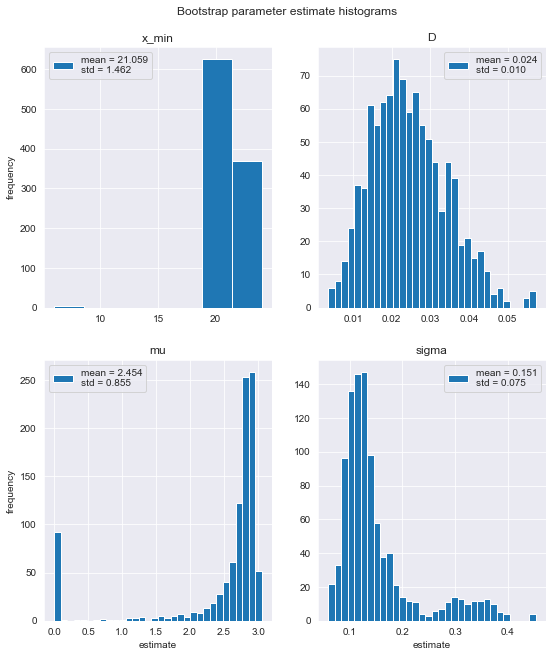

In [213]:
plot_bootstrap(dist, pos_ln)

## Stretched exponential

In [214]:
str_exp_noxmin = pd.read_csv('bootstrap_data/pitch_str_exp_bootstrap_1e3_xmin1.csv')

In [215]:
dist = Stretched_exponential(pitch, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [216]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 lambda = 0.8048642174205287
	 beta = 0.5157055788223575
	 D = 0.10253584843510993


In [217]:
get_p_values(dist, str_exp_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_lambda = 0.0
	 p_beta = 1.0


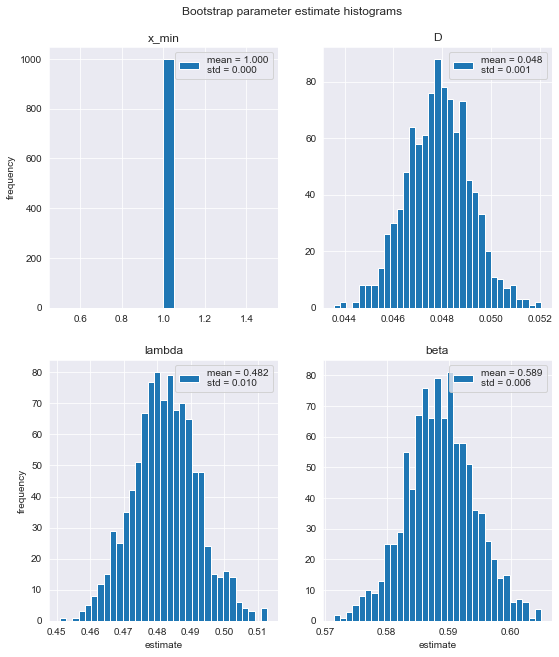

In [218]:
plot_bootstrap(dist, str_exp_noxmin)

In [219]:
str_exp_boot = pd.read_csv('bootstrap_data/pitch_str_exp_bootstrap_1e3.csv')

In [220]:
dist = Stretched_exponential(pitch)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [221]:
print_params(dist)

Fit parameters:
	 xmin = 5.0
	 lambda = 0.10536540915343907
	 beta = 1.7285296040973672
	 D = 0.04150534932686123


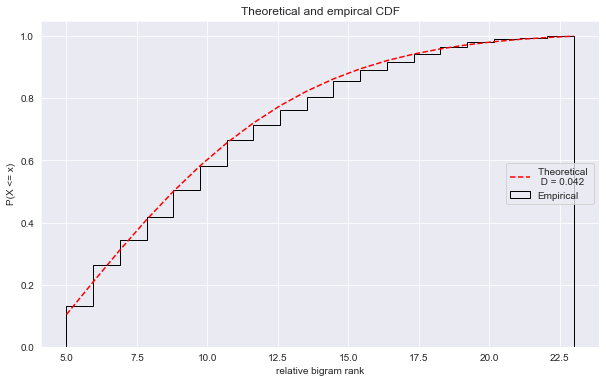

In [222]:
plot_ecdf(dist, dist.fit.stretched_exponential._pdf_base_function)

In [223]:
get_p_values(dist, str_exp_boot)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.999
	 p_lambda = 0.795
	 p_beta = 0.266


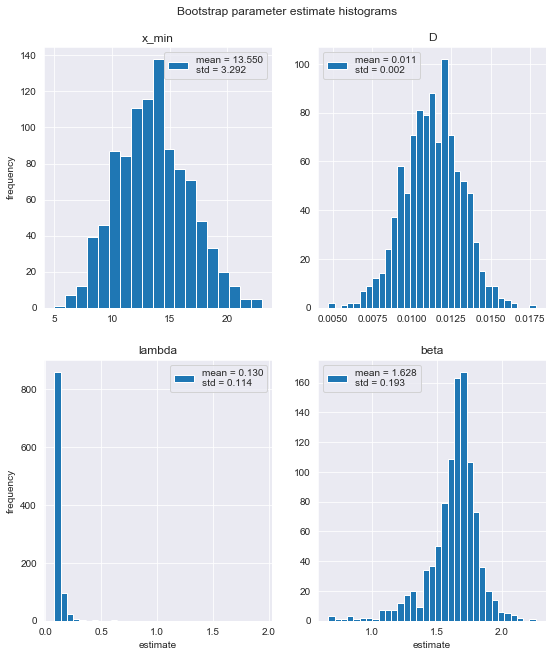

In [224]:
plot_bootstrap(dist, str_exp_boot)

----
## Power-law with cutoff

In [225]:
plcut_noxmin = pd.read_csv('bootstrap_data/pitch_pl_co_bootstrap_1e3_xmin1.csv')

In [226]:
dist = Powerlaw_with_cutoff(pitch, xmin=1)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [227]:
print_params(dist)

Fit parameters:
	 xmin = 1
	 alpha = 1.0447351108369523
	 lambda = 0.08728097769389276
	 D = 0.09445755429238828


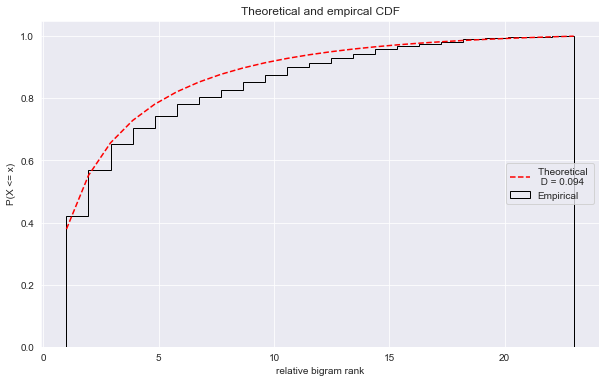

In [228]:
plot_ecdf(dist, dist.fit.truncated_power_law._pdf_base_function)

In [229]:
get_p_values(dist, plcut_noxmin)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.0
	 p_alpha = 0.0
	 p_lambda = 0.0


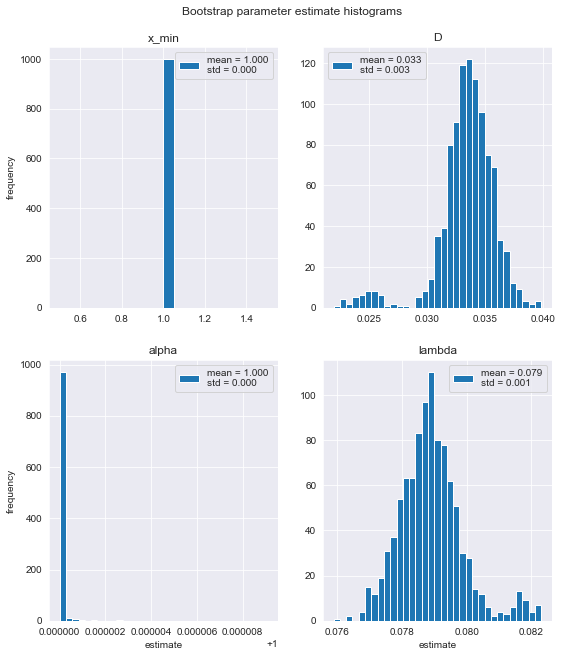

In [230]:
plot_bootstrap(dist, plcut_noxmin)

In [231]:
# Note: only 100 iterations
plcut = pd.read_csv('bootstrap_data/pitch_pl_co_bootstrap_100.csv')

In [232]:
dist = Powerlaw_with_cutoff(pitch)

/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [233]:
print_params(dist)

Fit parameters:
	 xmin = 2.0
	 alpha = 1.00000004613743
	 lambda = 0.08412132644096172
	 D = 0.052015779732720646


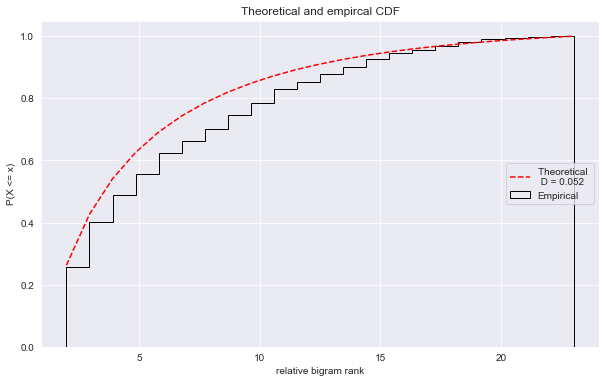

In [234]:
plot_ecdf(dist, dist.fit.truncated_power_law._pdf_base_function)

In [235]:
get_p_values(dist, plcut)

p-values:
	 p_D = 0.0000
	 p_xmin = 1.0
	 p_alpha = 1.0
	 p_lambda = 0.11


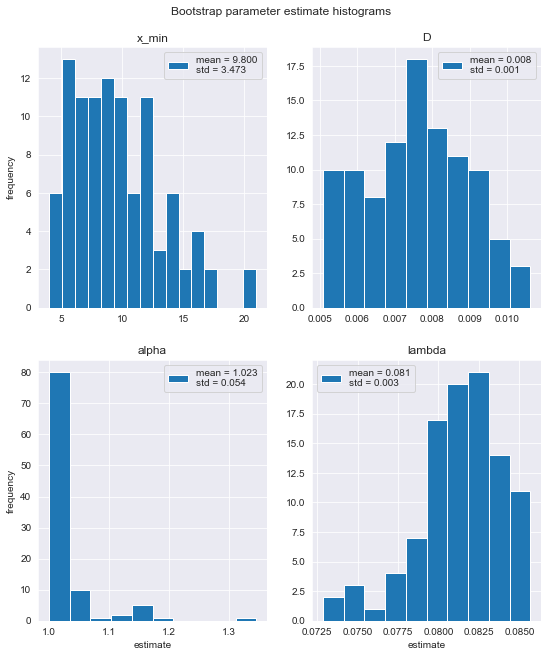

In [236]:
plot_bootstrap(dist, plcut, bin_norm=10)

## Power-law

In [237]:
pl_boot = pd.read_csv('bootstrap_data/pitch_pl_bootstrap_1e3.csv')

In [238]:
dist = Powerlaw(pitch)

Calculating best minimal value for power law fit
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/benlebrun/opt/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


In [239]:
print_params(dist)

Fit parameters:
	 xmin = 15.0
	 alpha = 6.760877447617291
	 D = 0.09302584205198405


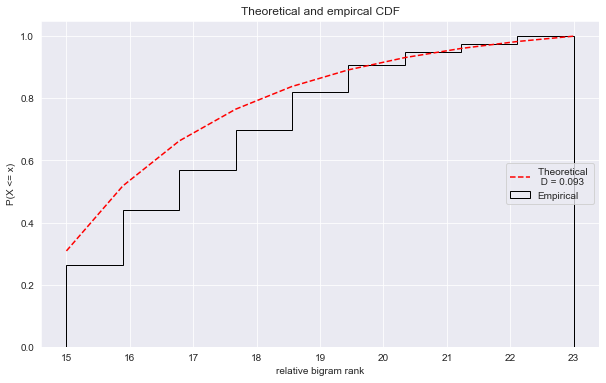

In [240]:
plot_ecdf(dist, dist.fit.power_law._pdf_base_function)

In [241]:
get_p_values(dist, pl_boot)

p-values:
	 p_D = 0.0000
	 p_xmin = 0.375
	 p_alpha = 0.223


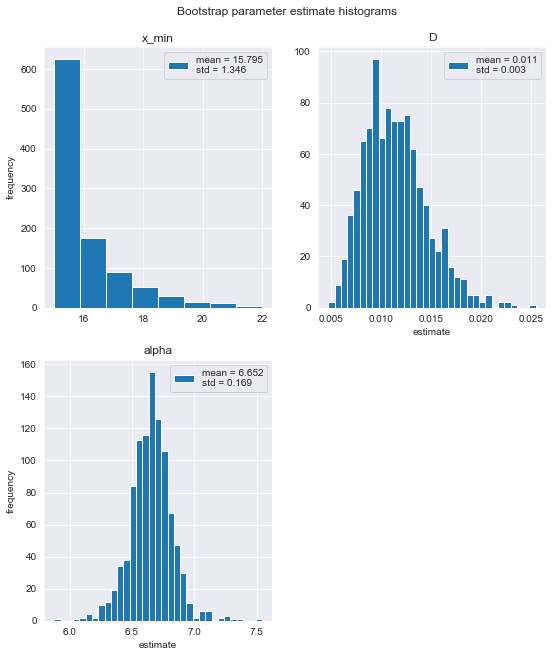

In [242]:
plot_bootstrap(dist, pl_boot)